In [ ]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:

comp = 'paddy-doctor/paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [4]:
path

Path('../input/paddy-doctor/paddy-disease-classification')

In [5]:
from fastai.vision.all import *
set_seed(42)
path.ls()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(#6) [Path('../input/paddy-doctor/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-doctor/paddy-disease-classification/train_images'),Path('../input/paddy-doctor/paddy-disease-classification/.jovianrc'),Path('../input/paddy-doctor/paddy-disease-classification/.ipynb_checkpoints'),Path('../input/paddy-doctor/paddy-disease-classification/train.csv'),Path('../input/paddy-doctor/paddy-disease-classification/test_images')]

In [6]:
df= pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [7]:
df.loc['100331.jpg','variety']

'ADT45'

In [8]:
def get_variety(p): return df.loc[p.name,'variety']

In [11]:
trn_path=path/'train_images'
files=get_image_files(trn_path)

In [13]:
dls= DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items= get_image_files,
    get_y= [parent_label, get_variety],
    splitter= RandomSplitter(0.2,seed=42),
    item_tfms= Resize(192,method='squish'),
    batch_tfms= aug_transforms(size=128,min_scale=0.75)
    
).dataloaders(trn_path)

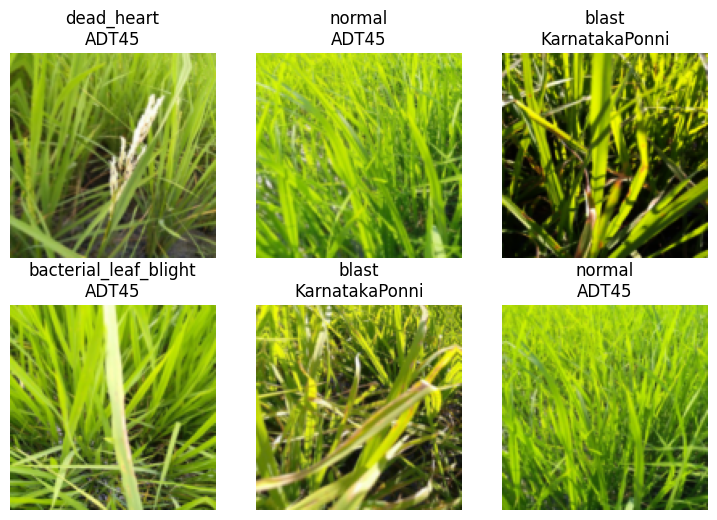

In [14]:
dls.show_batch(max_n=6)

In [15]:
def disease_err(inp,disease, variety): return error_rate(inp,disease)
def disease_loss(inp,disease, variety): return F.cross_entropy(inp, disease)

In [16]:
arch= 'convnext_small_in22k'
learn= vision_learner(dls, arch,loss_func= disease_loss, metrics= disease_err, n_out=10).to_fp16()
lr=0.01

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


In [17]:
learn.fine_tune(5,lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.264958,0.682101,0.240269,01:03


epoch,train_loss,valid_loss,disease_err,time
0,0.632253,0.473692,0.149447,01:00
1,0.510725,0.326437,0.113888,00:59
2,0.295088,0.187188,0.060067,00:59
3,0.192112,0.147666,0.043248,00:59
4,0.125017,0.138358,0.039885,00:59


In [18]:
learn= vision_learner(dls, arch, n_out= 20).to_fp16()

In [19]:
def disease_loss(inp,disease,variety): return F.cross_entropy(inp[:, :10], disease)

In [20]:
def variety_loss(inp, disease, variety): return F.cross_entropy(inp[:, 10: ], variety)

In [23]:
def disease_err(inp,disease,variety): return error_rate(inp[:,:10],disease)
def variety_err(inp,disease,variety): return error_rate(inp[:,10:],variety)
def combine_loss(inp, disease, variety): return disease_loss(inp, disease, variety)+variety_loss(inp,disease,variety)

In [28]:
err_metrics= (disease_err, variety_err)

In [29]:
all_metrics= err_metrics+ (disease_loss, variety_loss)

In [30]:
learn= vision_learner(dls, arch, loss_func= combine_loss, metrics= all_metrics, n_out= 20).to_fp16()

In [31]:
learn.fine_tune(5,lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,4.889563,3.064164,0.637194,0.304181,1.884538,1.179626,00:57


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,3.695132,2.830397,0.591543,0.301297,1.745557,1.084839,00:59
1,3.228807,2.580757,0.541086,0.290726,1.591951,0.988806,00:59
2,2.956927,2.444617,0.519942,0.291206,1.517937,0.926680,00:58
3,2.851454,2.397876,0.511773,0.286881,1.490159,0.907717,00:58
4,2.784285,2.394794,0.508890,0.288323,1.485923,0.908871,00:58


In [32]:
# ss['label']=results
# ss.to_csv('subm.csv',index=False)
# !head subm.csv

NameError: name 'results' is not defined